## GRACE water balance validation

This code takes output from a land surface model and spatially aggregates it to the 1x1 degree equal area mascons from the NASA Goddard Space Flight Center's [GRACE mascon solution](https://ssed.gsfc.nasa.gov/grace/products.html).

The code is in development to be generalizable to any appropriately formatted land surface model output. For development purposes, we are here working with data from the NASA Land Information System [LIS](https://lis.gsfc.nasa.gov/). 

We have converted LIS data from its native NetCDF4 format to an N-dimensional chunked array format called [Zarr](https://zarr.readthedocs.io/en/stable/). Each chunk is stored as an object on AWS S3. In order to gain access to the S3 buckets, the user will need to have entered their AWS credentials using the [AWS Command Line Interface](https://aws.amazon.com/cli/).

This work contributes to the NASA [HiMAT](https://himat.org) and NASA ACCESS awards (support of the [Pangeo project](http://pangeo-data.org/)). 

By Anthony Arendt, Landung Setiawan and Jonah Joughin

In [1]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data

import os
import sys
from datetime import datetime, timedelta
import h5py
from dask import compute
from distributed import Client
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import xarray as xr
import zarr
import scipy.optimize
from PyAstronomy import pyasl
from scipy import signal
from shapely.geometry import (Polygon, Point, box)
from PyAstronomy import pyasl

matplotlib.style.use('ggplot')

from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis, get_cmwe_trend_analysis, select_mascons, aggregate_mascons)
from himatpy.LIS import utils as LISutils
from himatpy.tools import animation_tools

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Read in the GRACE data

In [2]:
grace_file = os.path.abspath('GSFC.h5')
f = extract_grace(grace_file)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1, 148), type "<f8">
<HDF5 dataset "n_ref_days_window": shape (

In [3]:
mascon = f['mascon']
soln = f['solution']
time = f['time']

mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


## Open Zarr Store

In [4]:
fs = s3fs.S3FileSystem()
store = s3fs.S3Map(root='himat-data/store', s3=fs, check=False)
ds = xr.open_zarr(store)

## Connect to Dask Scheduler

In [5]:
client = Client('dask-scheduler:8786')

### Mask the model output to the GRACE mascons, and spatially aggregate
This step takes a few minutes. You can track progress [here](http://a126297be95ad11e88fc206aaaf0e532-2020999903.us-west-2.elb.amazonaws.com:8787/status).

In [6]:
masked_gdf = select_mascons(ds, mascon_gdf)
agg_data = aggregate_mascons(ds, masked_gdf, scale_factor = 86400)

### Convert to a Pandas Dataframe

In [27]:
A = agg_data['data']

names = ['products', 'mascons', 'time']
index = pd.MultiIndex.from_product([agg_data[n] for n in names], names=names)
df = pd.DataFrame({'A': A.flatten()}, index=index)['A']
df = df.unstack(level='products').swaplevel().sort_index()
df.columns = agg_data['products']
df.index.names = ['date','mascon']

### Following code is specific to LIS datasets

We calculate a water balance by combining the appropriate variables, grouped by each mascon. This generates a time series of water mass change per mascon.

In [59]:
lisdf = df.groupby('mascon').apply(lambda x: x.assign(WaterBalance = x.Rainf_tavg + x.Snowf_tavg - (x.Qsb_tavg + x.Qsm_tavg + x.Evap_tavg)))

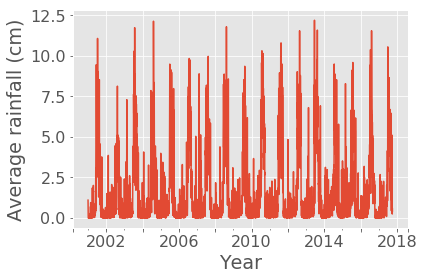

In [66]:
# Rain
rainp=lisdf['Rainf_tavg'].groupby('date').mean().plot()
rainp.set_ylabel('Average rainfall (cm)')
rainp.set_xlabel('Year')
for label in rainp.xaxis.get_ticklabels()[::2]: label.set_visible(False)
fig.savefig('Rain_ave.png')

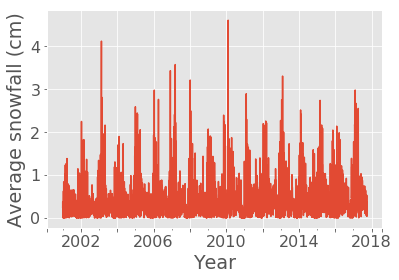

In [72]:
# Snow
snow=lisdf['Snowf_tavg'].groupby('date').mean().plot()
snow.set_ylabel('Average snowfall (cm)')
snow.set_xlabel('Year')
for label in snow.xaxis.get_ticklabels()[::2]: label.set_visible(False)
fig.savefig('Snowfall_ave.png')

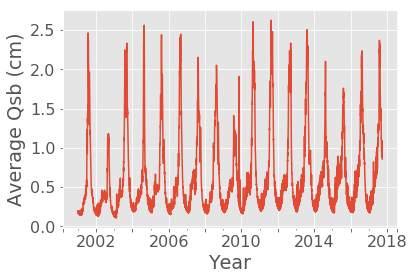

In [75]:
# Qsb
Qsb=lisdf['Qsb_tavg'].groupby('date').mean().plot()
Qsb.set_ylabel('Average Qsb (cm)')
Qsb.set_xlabel('Year')
for label in Qsb.xaxis.get_ticklabels()[::2]: label.set_visible(False)
fig.savefig('Qsb_ave.png')

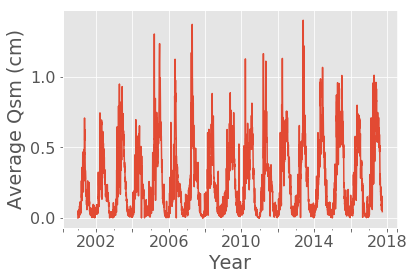

In [78]:
# Qsm
Qsm=lisdf['Qsm_tavg'].groupby('date').mean().plot()
Qsm.set_ylabel('Average Qsm (cm)')
Qsm.set_xlabel('Year')
for label in Qsm.xaxis.get_ticklabels()[::2]: label.set_visible(False)
fig.savefig('Qsm_ave.png')

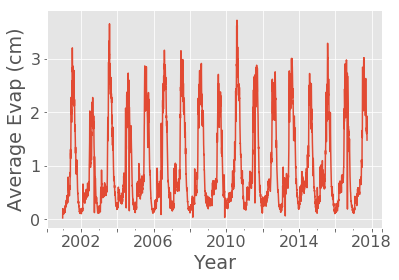

In [82]:
# Evap
Evap=lisdf['Evap_tavg'].groupby('date').mean().plot()
Evap.set_ylabel('Average Evap (cm)')
Evap.set_xlabel('Year')
for label in Evap.xaxis.get_ticklabels()[::2]: label.set_visible(False)
fig.savefig('Evap_ave.png')

### Plot of cumulative water balance over the full domain

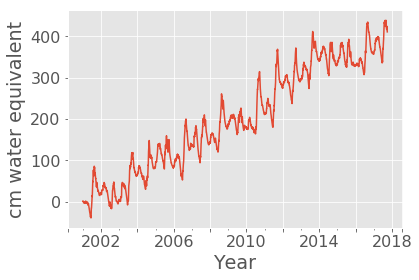

In [67]:
ax = lisdf['WaterBalance'].groupby('date').mean().cumsum().plot()
ax.set_ylabel('cm water equivalent')
ax.set_xlabel('Year')
for label in ax.xaxis.get_ticklabels()[::2]: label.set_visible(False)
fig.savefig('water equivalent.png')

### Convert GRACE time series to Pandas dataframe
Also convert the units of GRACE from cm to mm we

In [10]:
t = pd.DataFrame(data = {
    'time': f['time']["ref_days_middle"][0,:]
})

grc_lst = []
for m in agg_data['mascons']:
    df = pd.DataFrame(data={
        'mmwe': soln['cmwe'][m][:] * 10,
        'mascon': m
    })
    df.index = t['time'].apply(lambda x: datetime(2001,12,31) + timedelta(days=x))
    grc_lst.append(df)
    
gracedf = pd.concat(grc_lst)

## Calculate mean GRACE and LIS values by time 

In [11]:
grct = gracedf.groupby('time').mean()
wctst = lisdf.groupby('date').mean()
# clip to the same time period as GRACE
wctst = wctst.loc[grct.iloc[0].name:].cumsum()

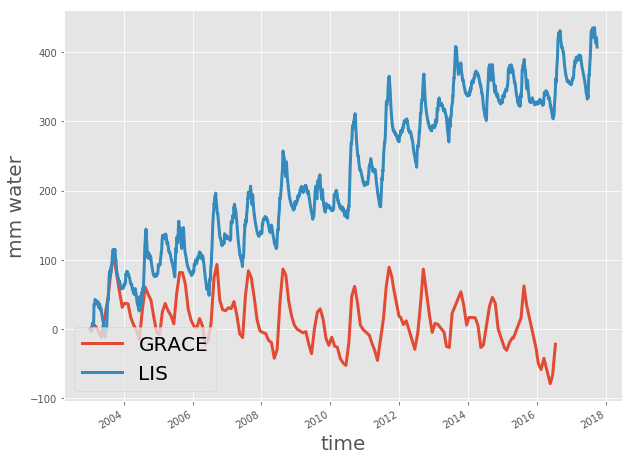

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 8))
(grct - grct.iloc[0].mmwe).plot(ax=ax, y='mmwe', linewidth = 3)
(wctst - wctst.iloc[0].WaterBalance).plot(ax=ax, y='WaterBalance', linewidth = 3)

plt.ylabel('mm water', fontsize = 20)
plt.xlabel('time', fontsize = 20)
ax.legend(['GRACE','LIS'],fontsize = 20, loc = 3)
font = {'family' : 'Times',
        'size'   : 16}
matplotlib.rc('font', **font)

### Detrend the LIS and GRACE data to assess how well interseasonal changes compare

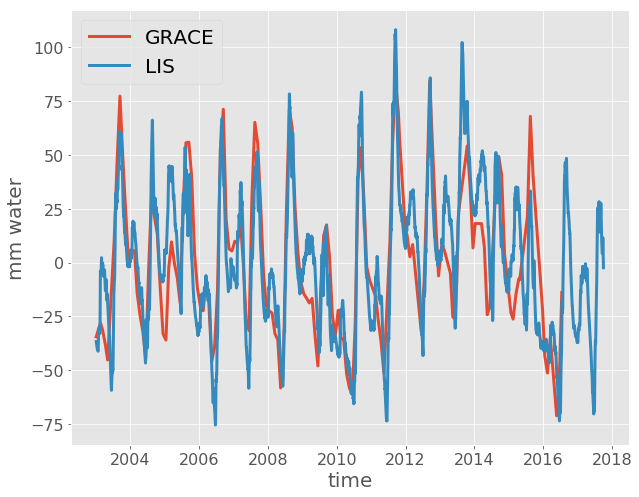

In [13]:
# detrending the LIS data

LIS_mass = wctst.WaterBalance.values
LIS_decyear = pd.Series(wctst.index).apply(lambda x: pyasl.decimalYear(x))

# detrending the GRACE data

GRACE_mass = grct.mmwe.values
GRACE_decyear = f['time']['yyyy_doy_yrplot_middle'][2, :]

# plot GRACE and LIS together
plt.figure(figsize=(10,8))
plt.plot(GRACE_decyear,signal.detrend(GRACE_mass, type = 'linear'),LIS_decyear,signal.detrend(LIS_mass, type = 'linear'),linewidth = 3)
plt.ylabel('mm water', fontsize = 20)
plt.xlabel('time', fontsize = 20)
plt.legend(['GRACE','LIS'],fontsize = 20, loc = 2)

font = {'family' : 'Times',
        'size'   : 16}

matplotlib.rc('font', **font)

### Code in development to do spatial plots

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
coordinates = [(62,26), (62,46), (106,46), (106, 26)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# create a geodataframe
HMA_region = gpd.GeoDataFrame()
HMA_region.loc[0, 'geometry'] = poly

In [15]:
HMA = mascon_gdf[(mascon_gdf['location'] == 80.0) & ((mascon_gdf['basin'] > 5000.0) & (mascon_gdf['basin'] < 6100.0))]

In [16]:
HMA_w_trend = get_cmwe_trend_analysis(HMA, f)

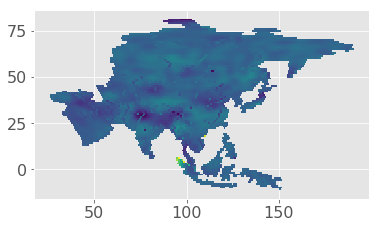

In [17]:
HMA_w_trend.plot(column='avg_mass_change_cm')

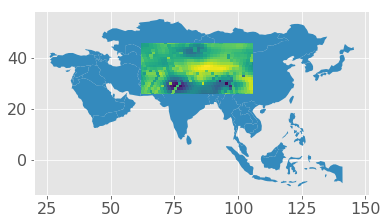

In [18]:
gpd_intersect = gpd.overlay(HMA_region, HMA_w_trend, how='intersection')
gpd_intersect.plot(column='avg_mass_change_cm', ax=world[world['continent'] == 'Asia'].plot(), figsize=(20, 20))

In [19]:
listdf.groupby('mascon').apply(lambda x: trend_analysis(x['time'].apply(lambda x: pyasl.decimalYear(x)), 
                                                   x['waterbal_cumulative'], optimization = True)[1] )

NameError: name 'listdf' is not defined